In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
## PCA with a linear Autoencoder ##

In [4]:
# Let's build a 3D dataset
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [5]:
# Now let's build the autoencoder
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [6]:
# Now let’s train the model on a simple generated 3D dataset and use it to encode that same dataset (i.e., project it to 2D)
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 1s 12ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 17ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 4ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 19ms/step - loss

In [7]:
# `codings` = latent representation (from 3D - original dataset to 2D - projection, just like PCA)
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


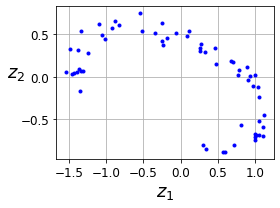

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

In [9]:
## Stacked Autoencoders ##

In [10]:
# Let's use the Fashion MNSIT dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255
X_test       = X_test.astype(np.float32)       / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [13]:
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 15s 8ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3165 - val_rounded_accuracy: 0.9004
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9201
Epoch 3/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2985 - val_rounded_accuracy: 0.9199
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [=================

In [88]:
# This function processes a few test images through the autoencoder and displays the original images and their reconstructions
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


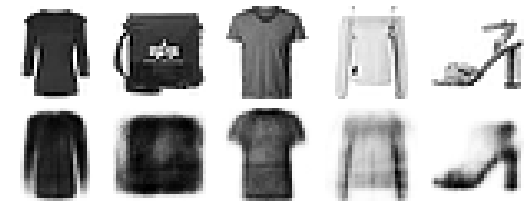

In [89]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

In [16]:
## Visualizing the Fashion MNIST dataset ##

# Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s
# dimensionality. For visualization, this does not give great results compared to other
# dimensionality reduction algorithms (such as those we discussed in Chapter 8), but
# one big advantage of autoencoders is that they can handle large datasets, with many
# instances and many features. So one strategy is to use an autoencoder to reduce the
# dimensionality down to a reasonable level, then use another dimensionality
# reduction algorithm for visualization. Let’s use this strategy to visualize Fashion
# MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimen‐
# sionality down to 30, then we use Scikit-Learn’s implementation of the t-SNE algo‐
# rithm to reduce the dimensionality down to 2 for visualization

In [17]:
np.random.seed(42)

from sklearn.manifold import TSNE

# `encodings` - 30 dimensions
X_valid_compressed = stacked_encoder.predict(X_valid)

# `tsne`      - 2 dimensions (by default)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


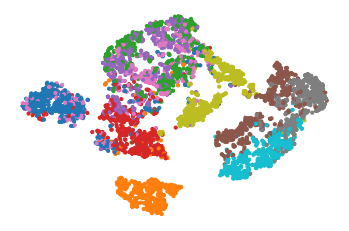

In [18]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


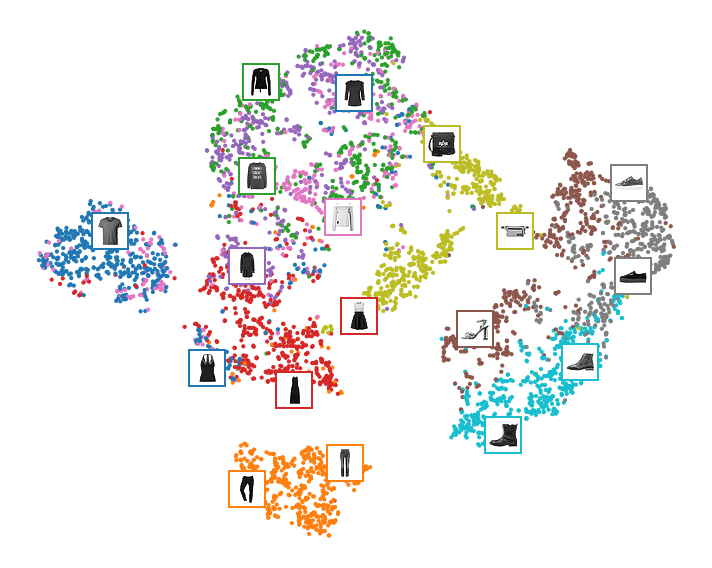

In [19]:
# Let's make this diagram a bit prettier
# Adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

In [20]:
# Now, let's look at a few techniques for training stacked autoencoders

In [21]:
## Tying Weights ##

In [22]:
# It is common to tie the weights of the encoder and the decoder,
# by simply using the transpose of the encoder's weights as the decoder weights.
# For this, we need to use a custom layer

In [23]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [25]:
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3014 - val_rounded_accuracy: 0.9093
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2873 - val_rounded_accuracy: 0.9316
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2860 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [=================

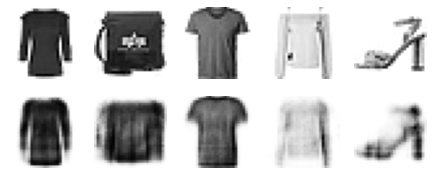

In [26]:
show_reconstructions(tied_ae)
plt.show()

In [27]:
## Convolutional Autoencoders ##

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME",  activation="selu"),
    keras.layers.Conv2DTranspose(1,  kernel_size=3, strides=2, padding="SAME",  activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [29]:
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 80s 46ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2845 - val_rounded_accuracy: 0.9294
Epoch 2/5
1719/1719 [==============================] - 80s 47ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 83s 48ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9497
Epoch 4/5
1719/1719 [==============================] - 73s 43ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2685 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 75s 44ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2672 - val_rounded_accuracy: 0.9507


In [30]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

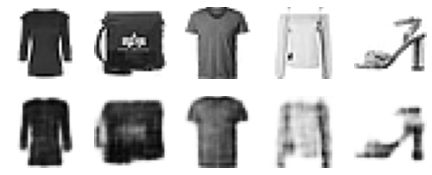

In [31]:
show_reconstructions(conv_ae)
plt.show()

In [32]:
## Recurrent Autoencoders ##

In [33]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1), metrics=[rounded_accuracy])

In [34]:
# history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

In [35]:
# This Recurrent Autoencoder doesn't perform well on images

In [36]:
## Stacked denoising Autoencoder ##

In [37]:
# Another way to force the autoencoder to learn useful features is to add noise to its
# inputs, training it to recover the original, noise-free inputs. 

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2), # enabled only on training mode (on inference mode is doing nothing)
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [39]:
history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [=================

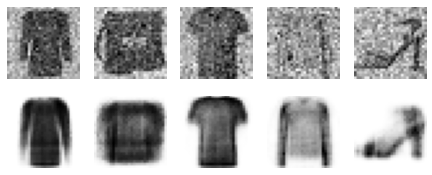

In [40]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [41]:
## Sparse Autoencoders ##

In [42]:
# Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build.
# This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1

In [43]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8992
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

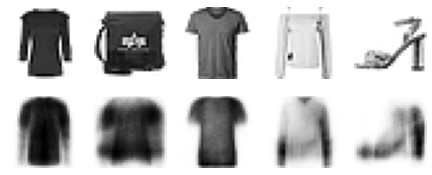

In [44]:
show_reconstructions(simple_ae)
plt.show()

In [45]:
# Let's create a couple functions to print nice activation histograms

In [46]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [47]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

In [48]:
# Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations.
# You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function.
# The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5.
# Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each.
# However, some neurons fire almost all the time (right side of the right histogram)

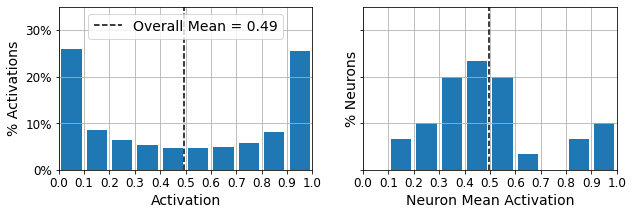

In [49]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [50]:
# Now let's add ℓ1 regularization to the coding layer
# We use ℓ1 regularization because it produces encodings close to 0 (it "zero out the weights" - zero out the neurons, in our case)

# Using the ℓ1 norm rather than the ℓ2 norm will push the neural network to preserve the most important codings while
# eliminating the ones that are not needed for the input image (rather than just reducing all codings)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

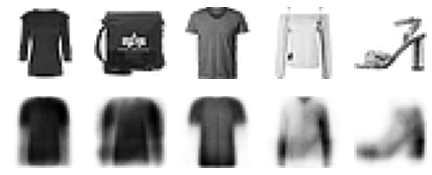

In [52]:
show_reconstructions(sparse_l1_ae)

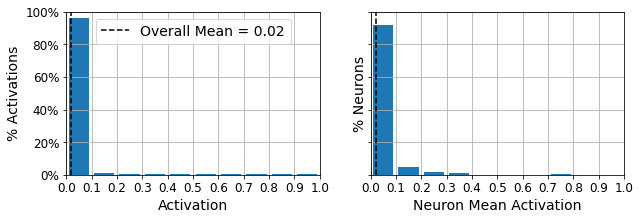

In [53]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Saving figure sparsity_loss_plot


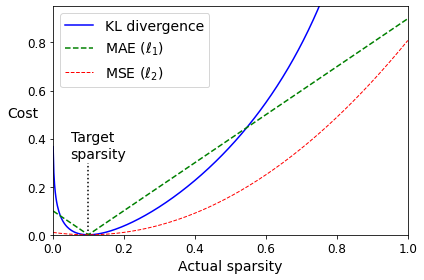

In [54]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)

kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)

plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)

plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")

plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [55]:
# Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
        
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [56]:
# Now we can build the sparse autoencoder, using the KLDivergenceRegularizer for the coding layer’s activations
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [57]:
history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

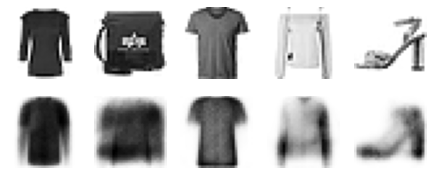

In [58]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


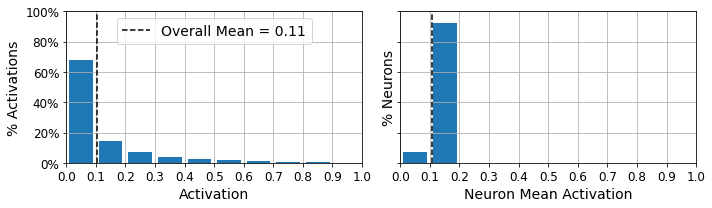

In [59]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

In [60]:
## Variational Autoencoder ##

In [61]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [62]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

codings_mean    = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [63]:
decoder_inputs = keras.layers.Input(shape=[codings_size])

x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)

variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [64]:
_, _, codings   = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

In [65]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 9s 19ms/step - loss: 0.3895 - rounded_accuracy: 0.8610 - val_loss: 0.3616 - val_rounded_accuracy: 0.8908
Epoch 2/25
430/430 [==============================] - 8s 18ms/step - loss: 0.3423 - rounded_accuracy: 0.8980 - val_loss: 0.3404 - val_rounded_accuracy: 0.9017
Epoch 3/25
430/430 [==============================] - 8s 18ms/step - loss: 0.3326 - rounded_accuracy: 0.9054 - val_loss: 0.3334 - val_rounded_accuracy: 0.9068
Epoch 4/25
430/430 [==============================] - 8s 18ms/step - loss: 0.3279 - rounded_accuracy: 0.9089 - val_loss: 0.3294 - val_rounded_accuracy: 0.9064
Epoch 5/25
430/430 [==============================] - 8s 18ms/step - loss: 0.3249 - rounded_accuracy: 0.9116 - val_loss: 0.3295 - val_rounded_accuracy: 0.9081
Epoch 6/25
430/430 [==============================] - 8s 18ms/step - loss: 0.3228 - rounded_accuracy: 0.9134 - val_loss: 0.3262 - val_rounded_accuracy: 0.9078
Epoch 7/25
430/430 [==========================

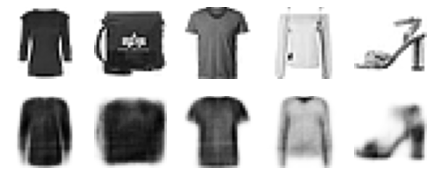

In [66]:
show_reconstructions(variational_ae)
plt.show()

In [67]:
## Generate Fashion Images ## 

In [68]:
# Now let’s use this variational autoencoder to generate images that look like fashion items
# All we need to do is sample random codings from a Gaussian distribution and decode them

In [69]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Saving figure vae_generated_images_plot


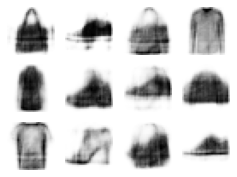

In [70]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

In [71]:
# Now let's perform semantic interpolation between these images

Saving figure semantic_interpolation_plot


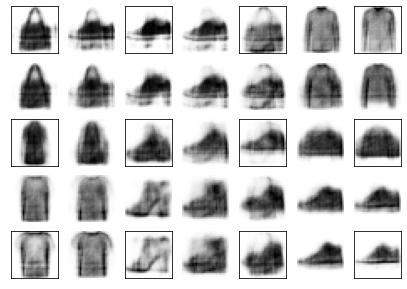

In [72]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

In [73]:
### GANs ###

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [75]:
# Phase 1: Train the discriminator (DON'T freeze the discriminator)
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Phase 2: Train the generator (freeze the discriminator)
# Obs.: The generator is trained through the `gan` model, so we don't need to compile it at all
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [76]:
# The trainable attribute is taken into account by Keras only when
# compiling a model, so after running this code, the discriminator
# is trainable if we call its fit() method or its train_on_batch()
# method (which we will be using), while it is not trainable when we
# call these methods on the gan model.

In [77]:
# Since the training loop is unusual, we cannot use the regular fit() method. Instead,
# we will write a custom training loop. For this, we first need to create a Dataset to
# iterate through the images

In [78]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [79]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # Phase 1 - Training the `discriminator`
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # Phase 2 - Training the `generator`
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size) # set target to 1 because we want the discriminator to belive that fake images (from generator) are real
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
        plot_multiple_images(generated_images, 8)
        plt.show()

In [80]:
## Deep Convolutional GANs ##

In [81]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [82]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [83]:
# Last layer from the generator uses the `tanh` activation function,
# so the outputs will range from –1 to 1. For this reason, before training the GAN,
# we need to rescale the training set to that same range. We also need to reshape it to add the channel dimension
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [84]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [85]:
# train_gan(gan, dataset, batch_size, codings_size)

In [1]:
## Exercises ##

In [3]:
# 1. What are the main tasks that autoencoders are used for?

# - Feature extraction
# - Denoising
# - Inpainting
# - Dimensionality reduction
# - Generative models

In [4]:
# 2. Suppose you want to train a classifier, and you have plenty of unlabeled training
# data but only a few thousand labeled instances. How can autoencoders help? How would you proceed?

# If you want to train a classifier and you have plenty of unlabeled training data but
# only a few thousand labeled instances, then you could first train a deep autoencoder
# on the full dataset (labeled + unlabeled), then reuse its lower half for the
# classifier (i.e., reuse the layers up to the codings layer, included) and train the
# classifier using the labeled data. If you have little labeled data, you probably want
# to freeze the reused layers when training the classifier.

In [5]:
# 3. If an autoencoder perfectly reconstructs the inputs, is it necessarily a good
# autoencoder? How can you evaluate the performance of an autoencoder?

# If an autoencoder perfectly reconstructs the inputs, it means that it's overfitting the
# training set and it will not generalize well on new instances.
# The autoencoder didn't learn any useful patterns from the data, it just learned to copy
# the inputs to the outputs (e.g.: overcomplete autoencoder).

# The fact that an autoencoder perfectly reconstructs its inputs does not necessarily
# mean that it is a good autoencoder; perhaps it is simply an overcomplete autoen‐
# coder that learned to copy its inputs to the codings layer and then to the outputs.
# In fact, even if the codings layer contained a single neuron, it would be possible
# for a very deep autoencoder to learn to map each training instance to a different
# coding (e.g., the first instance could be mapped to 0.001, the second to 0.002, the
# third to 0.003, and so on), and it could learn “by heart” to reconstruct the right
# training instance for each coding. It would perfectly reconstruct its inputs
# without really learning any useful pattern in the data. In practice such a mapping
# is unlikely to happen, but it illustrates the fact that perfect reconstructions are not
# a guarantee that the autoencoder learned anything useful. However, if it produces
# very bad reconstructions, then it is almost guaranteed to be a bad autoencoder.
# To evaluate the performance of an autoencoder, one option is to measure the
# reconstruction loss (e.g., compute the MSE, or the mean square of the outputs
# minus the inputs). Again, a high reconstruction loss is a good sign that the
# autoencoder is bad, but a low reconstruction loss is not a guarantee that it is
# good. You should also evaluate the autoencoder according to what it will be used
# for. For example, if you are using it for unsupervised pretraining of a classifier,
# then you should also evaluate the classifier’s performance.

In [6]:
# 4. What are undercomplete and overcomplete autoencoders? What is the main risk
# of an excessively undercomplete autoencoder? What about the main risk of an
# overcomplete autoencoder?

# Undercomplete: codings layer size < input/output layer size
# Overcomplete:  codings layer size > input/output layer size

# Undercomplete autoencoder - main risk: Not enough dimensions to learn representative features => may fail to reconstruct the inputs
# Overcomplete autoencoder  - main risk: It will learn by heart and won't generalize well       => may just copy the inputs to the outputs

In [7]:
# 5. How do you tie weights in a stacked autoencoder? What is the point of doing so?

# You use the same weights in the decoder as in the encoder, but in the reverse order
# e.g.: in encoder - conv2D, in decoder - conv2DTranspose

# To put it simply, make the decoder weights equal to the transposed of the encoder weights
# This reduces the number of parameters in the model by half => faster training
# This is also a form of regularization (reduces overfitting) 

In [8]:
# 6. What is a generative model? Can you name a type of generative autoencoder?

# A generative model is a model capable of randomly generating outputs that
# resemble the training instances. For example, once trained successfully on the
# MNIST dataset, a generative model can be used to randomly generate realistic
# images of digits. The output distribution is typically similar to the training data.
# For example, since MNIST contains many images of each digit, the generative
# model would output roughly the same number of images of each digit. Some
# generative models can be parametrized—for example, to generate only some
# kinds of outputs. An example of a generative autoencoder is the variational autoencoder (VAE).

In [9]:
# 7. What is a GAN? Can you name a few tasks where GANs can shine?

# GAN (Generative Adversarial Network) is composed of 2 NNs (Generator and Discriminator) which have opposing objectives.

# The `Discriminator` takes an instance (fake/real) and it's goal is to tell fake from real
# The `Generator` generates fake instances (similiar to those in the training set) and it's goal is to fool the Discriminator

# GANs are used for advanced image processing tasks such as
# super resolution, colorization, image editing (replacing objects with realistic
# background), turning a simple sketch into a photorealistic image, or predicting
# the next frames in a video. They are also used to augment a dataset (to train other models),
# to generate other types of data (such as text, audio, and time series), and
# to identify the weaknesses in other models and strengthen them.

In [10]:
# 8. What are the main difficulties when training GANs?

# Training GANs is notoriously difficult, because of the complex dynamics
# between the generator and the discriminator. The biggest difficulty is mode col‐
# lapse, where the generator produces outputs with very little diversity. Moreover,
# training can be terribly unstable: it may start out fine and then suddenly start
# oscillating or diverging, without any apparent reason. GANs are also very sensi‐
# tive to the choice of hyperparameters.

In [3]:
# 9. Try using a denoising autoencoder to pretrain an image classifier.
# You can use MNIST (the simplest option), or a more complex image dataset such as CIFAR10 if you want a bigger challenge.
# Regardless of the dataset you’re using, follow these steps:

# • Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
# • Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
# • Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set.
#   Does it perform better with or without pretraining?

In [4]:
# Split the dataset into a training set and a test set
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test  = X_test  / 255

170508288/170498071 [==============================] - 6s 0us/step


In [5]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [6]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [7]:
# Train a deep denoising autoencoder on the full training set

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

# Encoder
denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]), # adds noise only on training
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [9]:
denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 32, 32, 3)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
Non-

In [10]:
# Decoder
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="same", activation="sigmoid")
])

In [11]:
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 3)        867       
 nspose)                                                         
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [12]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(), metrics=["mse"])

In [13]:
history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 30s 12ms/step - loss: 0.5931 - mse: 0.0184 - val_loss: 0.5989 - val_mse: 0.0198
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5723 - mse: 0.0098 - val_loss: 0.5755 - val_mse: 0.0106
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.5675 - mse: 0.0080 - val_loss: 0.5721 - val_mse: 0.0093
Epoch 4/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.5654 - mse: 0.0072 - val_loss: 0.5715 - val_mse: 0.0091
Epoch 5/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.5642 - mse: 0.0067 - val_loss: 0.5684 - val_mse: 0.0078
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5632 - mse: 0.0063 - val_loss: 0.5668 - val_mse: 0.0072
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5625 - mse: 0.0061 - val_loss: 0.5661 - val_mse: 0.0069
Epoch 8/10
1563/1563 [==========================

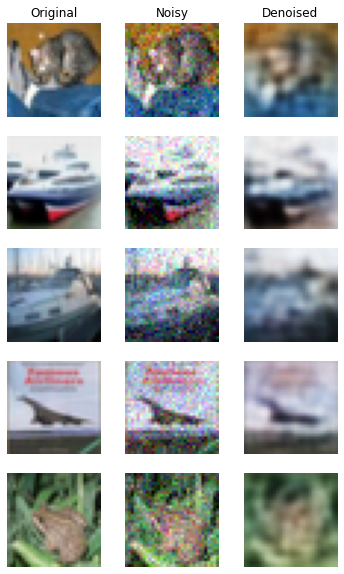

In [16]:
# Let's visualize 5 reconstructed images
n_images = 5

# Select first 5 images from the test set
new_images = X_test[:n_images]

# Add noise to them
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1

# Denoise them using the autoencoder
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')

    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')

    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    
    if index == 0:
        plt.title("Denoised")
plt.show()

In [35]:
# Let's build a classification DNN, reusing the lower layers of the autoencoder (encoder + codings)

In [36]:
clf = keras.models.Sequential([
    denoising_encoder,
    keras.layers.Dense(10, activation="softmax") # 10 classes
])

In [37]:
clf.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(), metrics="accuracy")

In [34]:
results = clf.evaluate(X_test, y_test)
results
# 59% accuracy before training the entire model (last layer's weights weren't trained)

313/313 [==============================] - 2s 4ms/step - loss: 1.1514 - accuracy: 0.5935


[1.1514164209365845, 0.593500018119812]

In [38]:
history = clf.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1468 - accuracy: 0.5942 - val_loss: 1.1525 - val_accuracy: 0.5986
Epoch 2/5
1563/1563 [==============================] - 10s 7ms/step - loss: 0.9441 - accuracy: 0.6658 - val_loss: 1.0899 - val_accuracy: 0.6224
Epoch 3/5
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8296 - accuracy: 0.7083 - val_loss: 1.0802 - val_accuracy: 0.6321
Epoch 4/5
1563/1563 [==============================] - 10s 7ms/step - loss: 0.7190 - accuracy: 0.7486 - val_loss: 1.1285 - val_accuracy: 0.6273
Epoch 5/5
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6232 - accuracy: 0.7819 - val_loss: 1.2107 - val_accuracy: 0.6228


In [39]:
results = clf.evaluate(X_test, y_test)
results
# 62% accuracy after training the entire model

313/313 [==============================] - 1s 3ms/step - loss: 1.2107 - accuracy: 0.6228


[1.2106705904006958, 0.6227999925613403]